In [1]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-07-13 14:57:23


In [2]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch.optim.lr_scheduler import ExponentialLR

import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
from scipy.spatial import cKDTree

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle
import gc

from joblib import Parallel, delayed
from tqdm import tqdm
import shutil
import joblib
import pathlib

from metpy.interpolate import interpolate_to_points

from scipy.ndimage import gaussian_filter1d

from data_loader import RTMA_sparse_to_dense_Dataset, Transform
from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedPSNR, MaskedSSIM

import os
import wandb, argparse, sys
from tqdm import tqdm

from data_loader import RTMA_sparse_to_dense_Dataset, Transform, NYSM_sparse_to_dense_Dataset
from models.Google_Unet import GoogleUNet
from models.Deep_CNN import DCNN
from models.UNet import UNet
from models.SwinT2_UNet import SwinT2UNet
from models.util import initialize_weights_xavier,initialize_weights_he

from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss

from sampler import DistributedEvalSampler

from util import str_or_none, int_or_none, bool_from_str, EarlyStopping, save_model_checkpoint, restore_model_checkpoint, init_zarr_store

FIG_DIR = '/home/harish/Dropbox/Apps/Overleaf/AIES_DL_based_Spatial_reconstruction_of_meteorological_variables_measured_by_sparse_stations'
if not os.path.exists(FIG_DIR):
    FIG_DIR = 'Figures'

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(torch.cuda.is_available())

True


In [4]:
from matplotlib.colors import ListedColormap
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = ListedColormap(turbo_colormap_data, name="turbo")

In [5]:
cap_alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
small_alphabets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                  'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Topography, masking, stations, and source data

In [6]:
# === Loading some topography and masking data ===
orography = xr.open_dataset('orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.set_coords(['latitude', 'longitude'])
orography = orography.orog

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values.astype(np.float32))

# Initiate the metrics
metrics = {
    'masked_rmse': MaskedRMSELoss(mask_tensor), 
    'masked_psnr': MaskedPSNR(mask_tensor),
    'masked_ssim': MaskedSSIM(mask_tensor),
}

# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1) # shape: (N, 2)

exclude_indices = [65, 102] # Exclude these indices, since they are falling outside the NYS mask region. 

print(nysm.iloc[[65,102]]['stid'])

# In the previous script, we kept the nysm_latlon and everything intact, without omitting the excluded indices.
# Later on, we conditionally excluded these indices based on the mask.
# Here, we will remove these indices from both nysm_latlon and nysm DataFrame
nysm_latlon = np.delete(nysm_latlon, exclude_indices, axis=0)
nysm = nysm.drop(index=exclude_indices).reset_index(drop=True)  # Drop the excluded indices from the DataFrame

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, RTMA_lat.shape)

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations

ref_zarr_store = 'data/RTMA.zarr'
test_dates_range = ['2023-01-01T00','2023-12-31T23']

# Load RTMA and NYSM once
RTMA_zarr_store = 'data/RTMA.zarr'
RTMA = xr.open_zarr(RTMA_zarr_store)
NYSM = xr.open_dataset('data/NYSM.nc')
NYSM['longitude'] = (NYSM['longitude'] + 360) % 360
NYSM_lat = NYSM.latitude.values
NYSM_lon = NYSM.longitude.values
station_points = np.stack([NYSM_lat.ravel(), NYSM_lon.ravel()], axis=-1)
tree = cKDTree(station_points)
_, station_indices = tree.query(nysm_latlon)
NYSM = NYSM.isel(station=station_indices)
# Now, since both nysm_latlon and NYSM are aligned, we can safely reset the station_indices
station_indices = np.arange(len(nysm_latlon))

print("nysm_latlon shape:", nysm_latlon.shape, "RTMA x_indices shape:", x_indices.shape, "RTMA y_indices shape:", y_indices.shape,"NYSM shape:", NYSM.station.shape)

missing_times = xr.open_dataset(f'nan_times_i10fg.nc').time
freq = 60  # Frequency in minutes, can be changed if needed
# if the additional input variables is not none, add the missing times of the additional input variables also. 
for var in ['si10','t2m','sh2']:
    missing_times = xr.concat([missing_times, xr.open_dataset(f'nan_times_{var}.nc').time], dim='time')
# remove duplicates
missing_times = missing_times.drop_duplicates('time')

65     MANH
102    STAT
Name: stid, dtype: object
nysm_latlon shape: (124, 2) RTMA x_indices shape: (124,) RTMA y_indices shape: (124,) NYSM shape: (124,)


In [7]:
# Create a mapping from original index to sorted index

# --- Sort NYSM stations based on latitude and longitude---
sorted_indices = np.argsort(NYSM['longitude'].values)  # primary: lon, secondary: lat

sorted_indices_map = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(station_indices[sorted_indices])}

## Visualizing NYS mesonet and gust frequency

In [8]:
# Compute gust frequencies
# https://www.weather.gov/mlb/wind_threat

NYSM_resampled = NYSM['i10fg'].sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59'))

# Based on the original RTMA paper, https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://ams.confex.com/ams/pdfpapers/152738.pdf&ved=2ahUKEwiBlL7i9fuNAxVIF1kFHXEwOXYQFnoECB0QAQ&usg=AOvVaw0OpFvCmMcUabt6D9HrfNo
# +-12 minutes is taken as the rolling window for gust frequency calculation
# Since the NYSM data is at 5 minutes frequency, we can use a rolling wind of 5 to cover -10 to +10 minutes around the gust time.

NYSM_resampled = NYSM_resampled.rolling(time=5, min_periods = 1, center=True).max()
NYSM_resampled = NYSM_resampled.sel(time=NYSM_resampled.time.dt.minute==0)

# Compute gust frequencies
gust_threshold = 17.5 #25.7  # m/s
gust_freq_nysm = (
    (NYSM_resampled 
     >= gust_threshold)
    .sum(dim='time')
)

gust_freq_rtma = (RTMA.i10fg.sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59'))
                   >= gust_threshold).sum(dim='time').values[y_indices, x_indices]

In [9]:
# Compute the pearsons correlation coefficient between the gust

# Ensure shapes: (time, station)
y = NYSM_resampled.T.values  # shape: (time, n_stations)
x = RTMA.i10fg.sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59')).values[:, y_indices, x_indices]  # shape: (time, n_stations)

assert y.shape == x.shape, f"Shape mismatch: NYSM {y.shape}, RTMA {x.shape}"

def compute_corr(y_col, x_col):
    y_1d = y_col.ravel()
    x_1d = x_col.ravel()
    valid_mask = ~np.isnan(y_1d) & ~np.isnan(x_1d)
    if np.sum(valid_mask) < 2:
        return np.nan  # Not enough valid data
    return np.corrcoef(y_1d[valid_mask], x_1d[valid_mask])[0, 1]

# Cap to max 128 CPUs
n_jobs = min(128, os.cpu_count())

# Use tqdm with Parallel
correlations = Parallel(n_jobs=n_jobs)(
    delayed(compute_corr)(y[:, i], x[:, i]) for i in tqdm(range(y.shape[1]), desc="Computing Pearson per station")
)
correlations = np.array(correlations)

Computing Pearson per station: 100%|██████████| 124/124 [00:00<00:00, 804.77it/s]


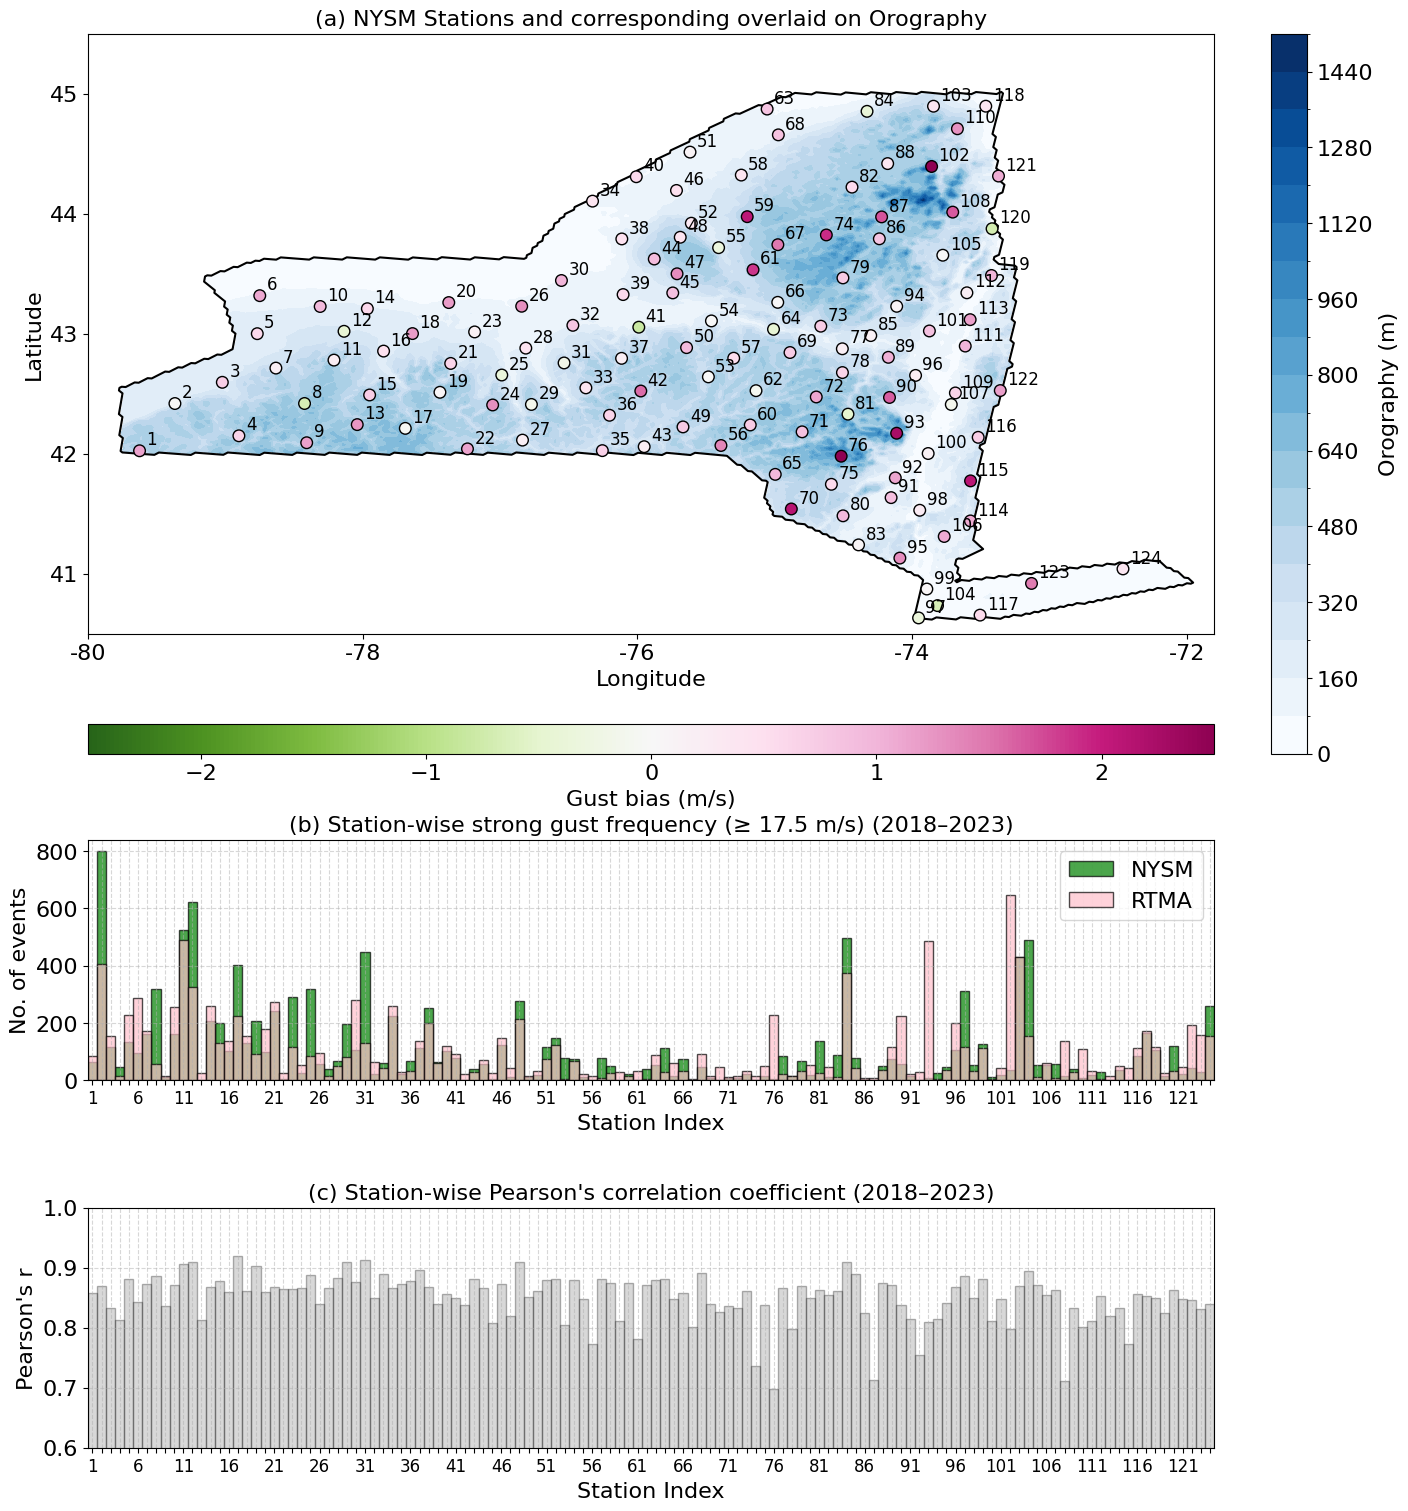

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fontsize = 16

# Extract coordinates and values
lon = NYSM['longitude'].values
lat = NYSM['latitude'].values


lat_sorted = lat[sorted_indices]
lon_sorted = lon[sorted_indices]

# Set up 1x2 subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 15), constrained_layout=True,gridspec_kw={'height_ratios': [3, 1,1], 'hspace': 0.1})

# === Add domain outline using the mask ===
outline = mask.plot.contour(
    ax=axes[0],
    x='longitude',
    y='latitude',
    colors='black',
    linewidths=1.5,
    levels=[0.5],  # level between 0 and 1 to get the boundary
    add_colorbar=False
)

# === Plot 1: Orography + Station Locations + Indices ===
contour = orography.where(mask).plot.contourf(
    ax=axes[0],
    x='longitude',
    y='latitude',
    levels=20,
    cmap='Blues',
    add_colorbar=True
)
# Set plot limits
axes[0].set_xlim(280, 288.2)
axes[0].set_ylim(40.5, 45.5)
# Set custom tick labels on the same positions
xticks = np.arange(280, 290, 2)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([f"{x - 360 if x > 180 else x}" for x in xticks])
contour.colorbar.set_label('Orography (m)', fontsize=fontsize)
contour.colorbar.ax.tick_params(labelsize=fontsize)

# === Scatter plot for NYSM stations with bias as color ===
gust_bias = RTMA.i10fg.sel(time=slice('2018-01-01T00:00', '2023-12-31T23:59')).mean(dim='time').values[y_indices, x_indices] - NYSM_resampled.mean(dim='time').values 
# Sort gust_bias, gust_freq_nysm, gust_freq_rtma using same order
gust_bias_sorted = gust_bias[sorted_indices]

cmap_bias = 'PiYG_r'
norm_bias = TwoSlopeNorm(vmin=-2.5, vcenter=0, vmax=2.5)
sc2 = axes[0].scatter(
    lon_sorted,
    lat_sorted,
    c=gust_bias_sorted,
    cmap=cmap_bias,
    norm=norm_bias,
    edgecolor='black',
    s=70,
    zorder = 3
)
divider2 = make_axes_locatable(axes[0])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.9)
cb2 = fig.colorbar(sc2, cax=cax2, orientation='horizontal')
cb2.set_label('Gust bias (m/s)', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize)

for i, (x, y) in enumerate(zip(lon_sorted, lat_sorted)):
    axes[0].text(x + 0.05, y + 0.05, str(i+1), fontsize=12, color='black', zorder=4)

axes[0].set_title(f'({small_alphabets[0]}) NYSM Stations and corresponding overlaid on Orography', fontsize=fontsize)
axes[0].set_xlabel('Longitude', fontsize=fontsize)
axes[0].set_ylabel('Latitude', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)

# === Plot 2: Bar plot of gust frequency ===
gust_freq_nysm_sorted = gust_freq_nysm.values[sorted_indices]
gust_freq_rtma_sorted = gust_freq_rtma[sorted_indices]

station_indices_sorted = np.arange(len(lat_sorted))
axes[1].bar(station_indices_sorted, gust_freq_nysm_sorted, width=1, label='NYSM', color='green', edgecolor='black', alpha=0.7)
axes[1].bar(station_indices_sorted, gust_freq_rtma_sorted, width=1, label='RTMA', color='pink', edgecolor='black', alpha=0.7)

axes[1].set_xlabel('Station Index', fontsize=fontsize)
axes[1].set_ylabel('No. of events', fontsize=fontsize)
axes[1].set_title(f'({small_alphabets[1]}) Station-wise strong gust frequency (≥ 17.5 m/s) (2018–2023)', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)
axes[1].set_xticks(station_indices_sorted)
# Show labels only at every 5th index, hide others by setting them as empty strings
xtick_labels = [str(i+1) if i % 5 == 0 else '' for i in station_indices_sorted]
axes[1].set_xticklabels(xtick_labels, fontsize=12)
axes[1].legend(fontsize=fontsize)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlim(-0.5, len(lat_sorted) - 0.5)

# === Plot 3: Bar plot of Pearson's correlation coefficients ===
correlations_sorted = correlations[sorted_indices]
axes[2].bar(station_indices_sorted, correlations_sorted, width=1, color='grey', edgecolor='black', alpha=0.3)
axes[2].set_xlabel('Station Index', fontsize=fontsize)
axes[2].set_ylabel('Pearson\'s r', fontsize=fontsize)
axes[2].set_title(f'({small_alphabets[2]}) Station-wise Pearson\'s correlation coefficient (2018–2023)', fontsize=fontsize)
axes[2].tick_params(labelsize=fontsize)
axes[2].set_xticks(station_indices_sorted)
# Show labels only at every 5th index, hide others by setting them as empty strings
xtick_labels = [str(i+1) if i % 5 == 0 else '' for i in station_indices_sorted]
axes[2].set_xticklabels(xtick_labels, fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].set_ylim(0.6, 1)  # Set y-axis limits for better visibility\
axes[2].set_xlim(-0.5, len(lat_sorted) - 0.5)

plt.savefig(os.path.join(FIG_DIR, 'gust_frequency.png'), dpi=300)

# Visualizing the ramdom stations

In [11]:
from sklearn.neighbors import BallTree

def get_distances(lat_lon: np.ndarray, k: int):
    # Convert degrees to radians
    lat_lon_rad = np.radians(lat_lon)
    
    # Use haversine metric in BallTree
    tree = BallTree(lat_lon_rad, metric='haversine')
    dist, _ = tree.query(lat_lon_rad, k=k + 1)
    dist = dist[:, 1:]  # Exclude self-distance

    # Convert radians to km (Earth radius = 6371 km)
    dist_km = dist * 6371

    return dist_km

In [12]:
"""
The stations (original) have been saved by name, which itself is pretty much random.
Thus, either we could leave the order as it, and divide them into four groups wich 31 stations in each.
Or, we could randomize them and divide into four groups of 31 stations each, such that the groups represent similar mean distance. 
"""

'\nThe stations (original) have been saved by name, which itself is pretty much random.\nThus, either we could leave the order as it, and divide them into four groups wich 31 stations in each.\nOr, we could randomize them and divide into four groups of 31 stations each, such that the groups represent similar mean distance. \n'

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import numpy as np

def make_four_diverse_groups(latlon: np.ndarray, total_groups: int = 4, subset_size: int = 31, random_state: int = 42):
    assert total_groups * subset_size <= latlon.shape[0], "Not enough stations to divide."

    # Step 1: Fine-grain KMeans to get 124 micro-clusters
    n_clusters = total_groups * subset_size
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(latlon)
    centers = kmeans.cluster_centers_

    # Step 2: From each cluster, select closest station to its center
    representatives = []
    for cluster_id in range(n_clusters):
        idxs = np.where(labels == cluster_id)[0]
        if len(idxs) == 0:
            continue  # Shouldn’t happen but safe check
        elif len(idxs) == 1:
            representatives.append(idxs[0])
        else:
            closest_idx = idxs[
                pairwise_distances_argmin(centers[cluster_id][None, :], latlon[idxs])
            ][0]
            representatives.append(closest_idx)

    # Step 3: Shuffle and split into 4 groups of 31
    representatives = np.array(representatives)
    np.random.seed(random_state)
    np.random.shuffle(representatives)
    groups = [representatives[i * subset_size: (i + 1) * subset_size] for i in range(total_groups)]

    return groups


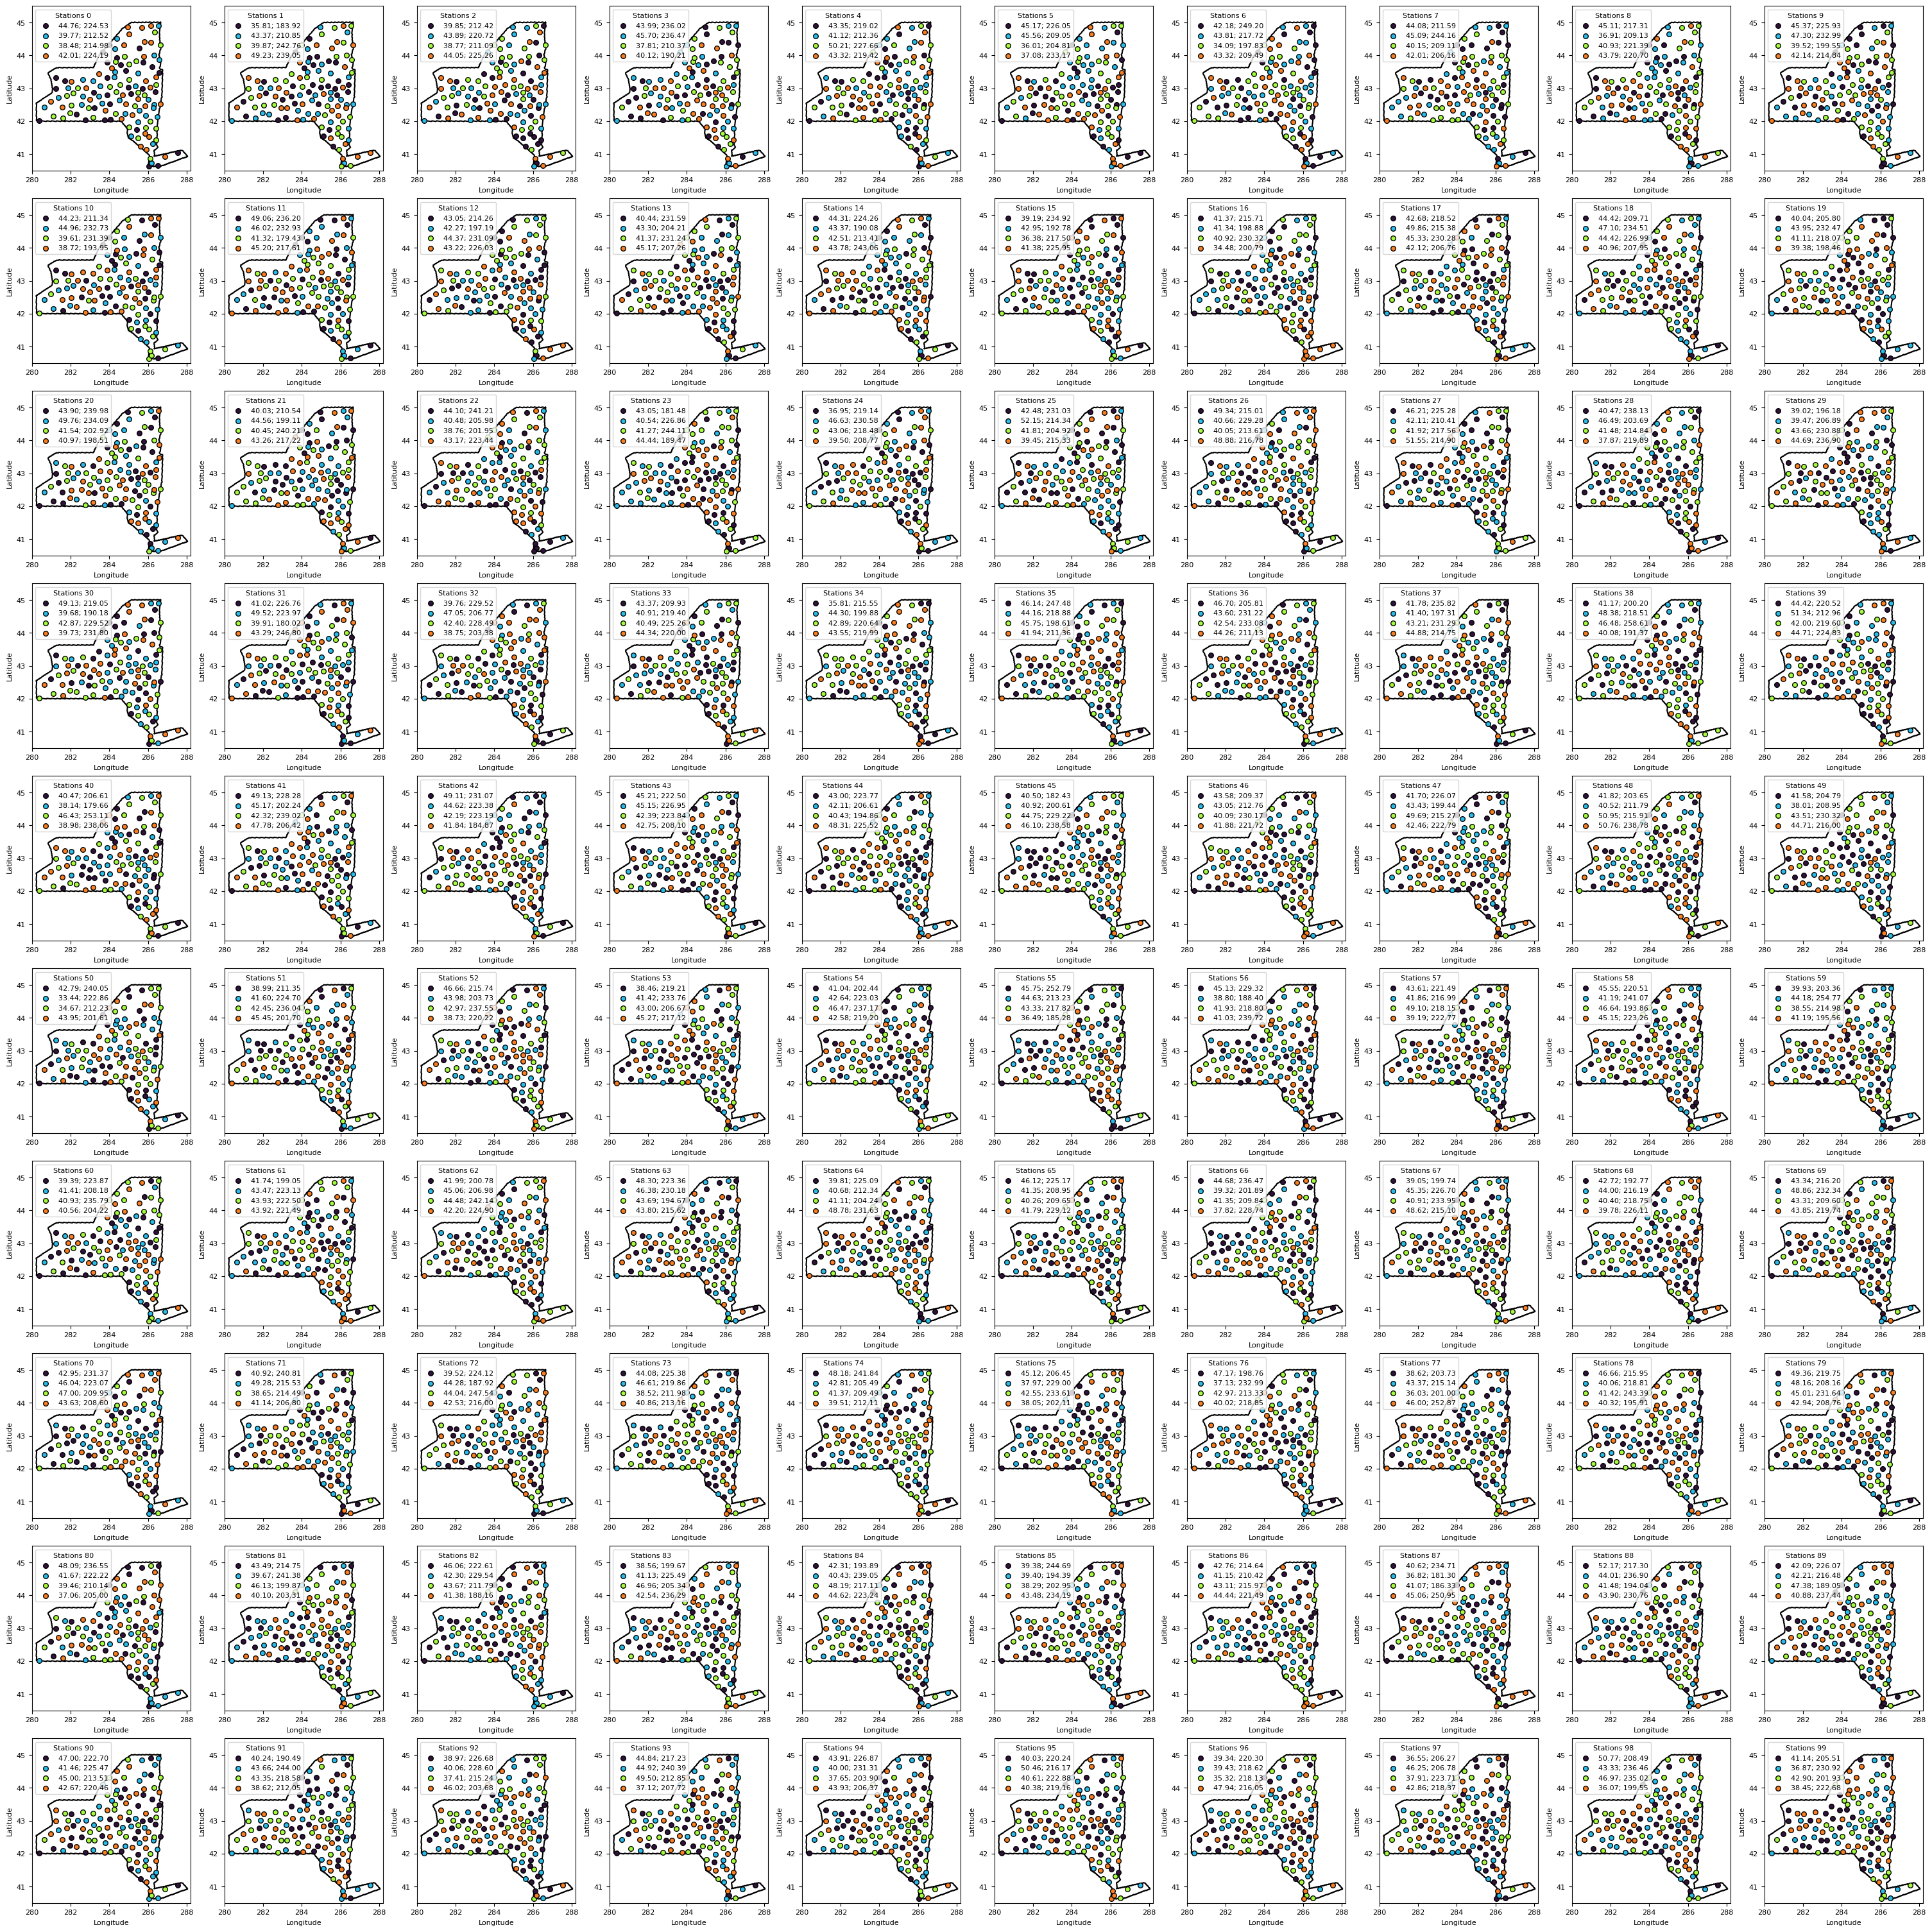

In [ ]:
# Set up 1x2 subplots
fig, axes = plt.subplots(10, 10, figsize=(30, 30), constrained_layout=True)
fontsize = 8

for random_state in np.arange(0,100):
    selected_groups = make_four_diverse_groups(nysm_latlon,random_state=random_state)

    ax = axes[random_state // 10, random_state % 10]

    mask.plot.contour(
    ax=ax,
    x='longitude',
    y='latitude',
    colors='black',
    linewidths=1.5,
    levels=[0.5],  # level between 0 and 1 to get the boundary
    add_colorbar=False
    )

    # First group stations
    for group_idx, group in enumerate(selected_groups):
        dist1 = get_distances(nysm_latlon[group], k=1)
        dist2 = get_distances(nysm_latlon[group], k=30)
        ax.scatter(
            NYSM['longitude'].values[group],
            NYSM['latitude'].values[group],
            edgecolor='black',
            c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
            label=f'{np.mean(dist1):.2f}; {np.mean(dist2):.2f}',
            s=30,
            zorder = 3
        )   

    # Set plot limits
    ax.set_xlim(280, 288.2)
    ax.set_ylim(40.5, 45.5)
    ax.set_xlabel('Longitude', fontsize=fontsize)
    ax.set_ylabel('Latitude', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

    ax.legend(title=f'Stations {random_state}', fontsize=fontsize, title_fontsize=fontsize)

plt.savefig(os.path.join(FIG_DIR, 'diverse_groups.pdf'), dpi=300)

- From the figure, we find groups from random_state = 4 were much dispersed

In [8]:
"""
random_state = 4
selected_groups = make_four_diverse_groups(nysm_latlon,random_state=random_state)

with open("selected_groups.pkl", "wb") as f:
    pickle.dump(selected_groups, f)
"""

'\nrandom_state = 4\nselected_groups = make_four_diverse_groups(nysm_latlon,random_state=random_state)\n\nwith open("selected_groups.pkl", "wb") as f:\n    pickle.dump(selected_groups, f)\n'

In [8]:
with open("selected_groups.pkl", "rb") as f:
    selected_groups = pickle.load(f)

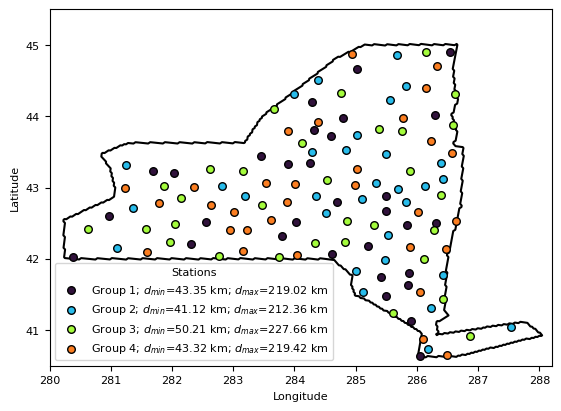

In [15]:
# Set up 1x2 subplots
fig, ax = plt.subplots(1,1, figsize=(5.5, 4), constrained_layout=True)
fontsize = 8

mask.plot.contour(
ax=ax,
x='longitude',
y='latitude',
colors='black',
linewidths=1.5,
levels=[0.5],  # level between 0 and 1 to get the boundary
add_colorbar=False
)

# First group stations
for group_idx, group in enumerate(selected_groups):
    dist1 = get_distances(nysm_latlon[group], k=1)
    dist2 = get_distances(nysm_latlon[group], k=30)
    ax.scatter(
        NYSM['longitude'].values[group],
        NYSM['latitude'].values[group],
        edgecolor='black',
        c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
        label=fr'Group {group_idx+1}; $d_{{min}}$={np.mean(dist1):.2f} km; $d_{{max}}$={np.mean(dist2):.2f} km',
        s=30,
        zorder = 3
    )   

# Set plot limits
ax.set_xlim(280, 288.2)
ax.set_ylim(40.5, 45.5)
ax.set_xlabel('Longitude', fontsize=fontsize)
ax.set_ylabel('Latitude', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

ax.legend(title=f'Stations', fontsize=fontsize, title_fontsize=fontsize)

#plt.savefig(os.path.join(FIG_DIR, 'diverse_groups.pdf'), dpi=300)

In [ ]:
"""
inference_stations_list = {}
n_infer_93 = {}
n_infer_93['fold_0'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1,2]]), 'test':selected_groups[3]}
n_infer_93['fold_1'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1,3]]), 'test':selected_groups[2]}
n_infer_93['fold_2'] = {'inference':np.concatenate([selected_groups[j] for j in [0,2,3]]), 'test':selected_groups[1]}
n_infer_93['fold_3'] = {'inference':np.concatenate([selected_groups[j] for j in [1,2,3]]), 'test':selected_groups[0]}

inference_stations_list['n_infer_93'] = n_infer_93

n_infer_62 = {}
n_infer_62['fold_0'] = {'inference':np.concatenate([selected_groups[j] for j in [0,1]]), 'test':np.concatenate([selected_groups[j] for j in [2,3]])}
n_infer_62['fold_1'] = {'inference':np.concatenate([selected_groups[j] for j in [0,3]]), 'test':np.concatenate([selected_groups[j] for j in [1,2]])}
n_infer_62['fold_2'] = {'inference':np.concatenate([selected_groups[j] for j in [2,3]]), 'test':np.concatenate([selected_groups[j] for j in [0,1]])}
n_infer_62['fold_3'] = {'inference':np.concatenate([selected_groups[j] for j in [1,2]]), 'test':np.concatenate([selected_groups[j] for j in [0,3]])}
n_infer_62['fold_4'] = {'inference':np.concatenate([selected_groups[j] for j in [0,2]]), 'test':np.concatenate([selected_groups[j] for j in [1,3]])}
n_infer_62['fold_5'] = {'inference':np.concatenate([selected_groups[j] for j in [1,3]]), 'test':np.concatenate([selected_groups[j] for j in [0,2]])}

inference_stations_list['n_infer_62'] = n_infer_62

# Save the inference stations list to pickle file
import pickle
with open('inference_stations_list.pkl', 'wb') as f:
    pickle.dump(inference_stations_list, f)
"""

In [9]:
with open(f"inference_stations_list.pkl", "rb") as f:
    inference_stations_list = pickle.load(f)

n_inference_stations,fold = 93,0
inference_stations_list[f'n_infer_{n_inference_stations}'][f'fold_{fold}']['inference']

array([ 21,  99,  32,  26,   9,  80, 103,  70,  10,   1,  82,  55,  49,
        14,  66,  93,  27,  33,  54,  23,  65,  77,  76,  35,  28,   7,
        57,  12,  19, 110, 116, 107,  47,  83, 115,  15,  97,  68,  81,
       100,  98,  38,  25,  64,  36,  52,  74, 117,  18,  67,  71,  48,
        59, 120,  75,  84,  41,  24,  96,  94,  88,  37,  40,   4, 123,
        62,  20,  46,  85, 118,  78,  11,  58,  42,  87,  73,  95,   2,
         6, 114,  39, 111, 105,   0,  44, 102,  92,  86,  53,  51,  34,
        61, 122])

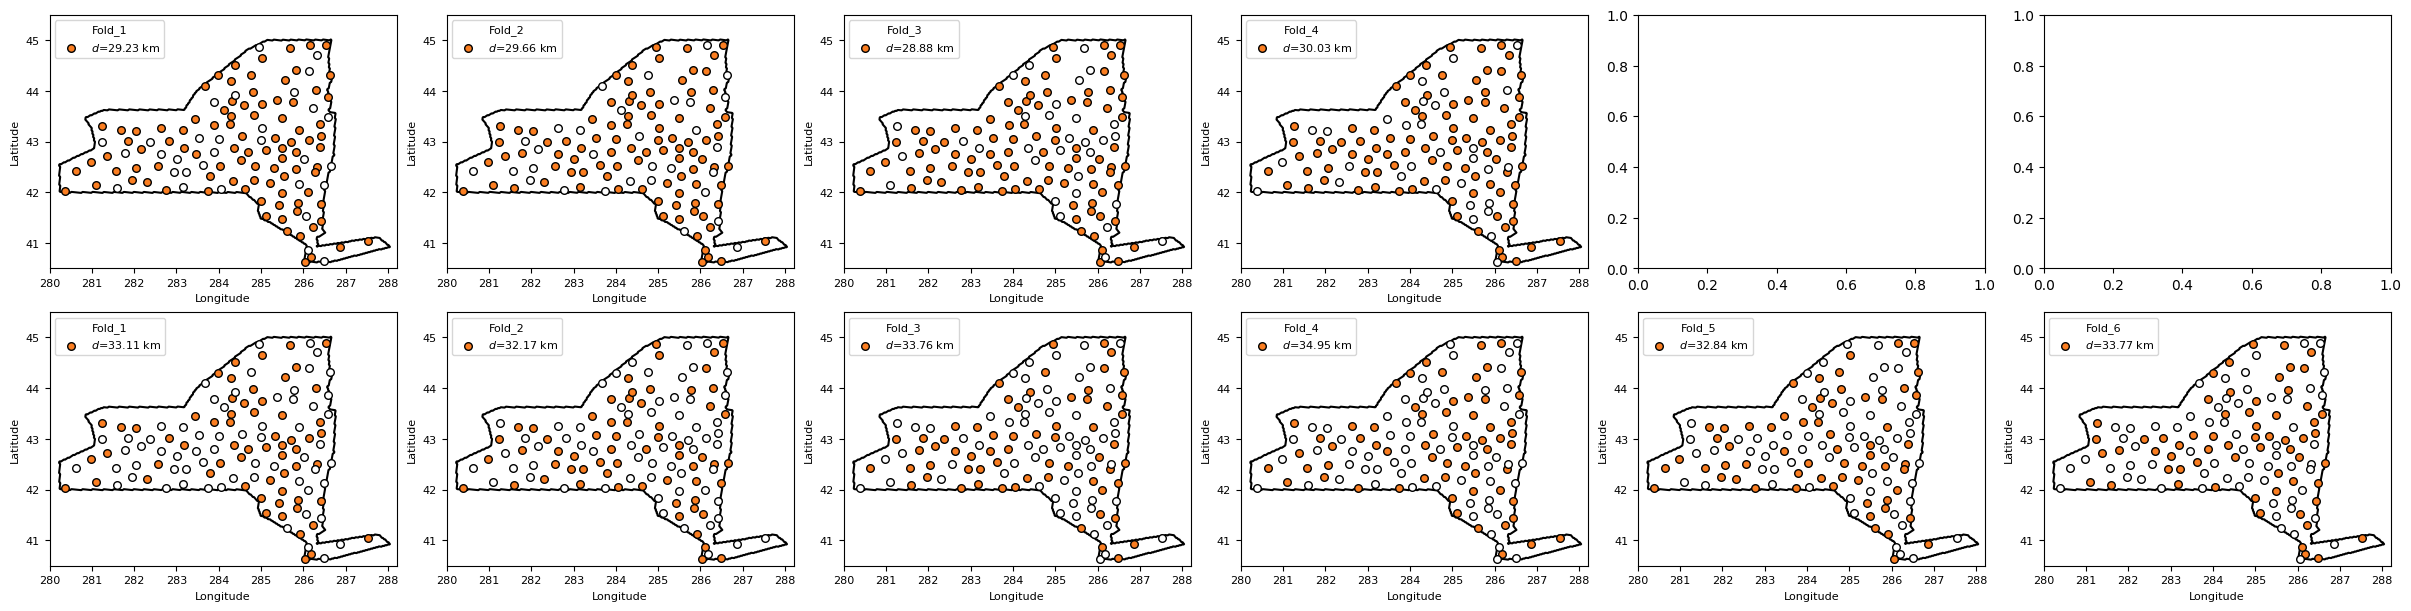

In [15]:
# Set up 1x2 subplots
fig, axes = plt.subplots(2, 6, figsize=(24, 6), constrained_layout=True)
fontsize = 8

for i in range(len(inference_stations_list)):
    experiment_name = list(inference_stations_list.keys())[i]
    folds = inference_stations_list[experiment_name]
    for j, (fold_name, split) in enumerate(folds.items()):
        # Plot the stations for this fold
        ax = axes[i, j]
        mask.plot.contour(
        ax=ax,
        x='longitude',
        y='latitude',
        colors='black',
        linewidths=1.5,
        levels=[0.5],  # level between 0 and 1 to get the boundary
        add_colorbar=False
        )
        dist = get_distances(nysm_latlon[split['inference']], k=1)
        ax.scatter(
            NYSM['longitude'].values[split['inference']],
            NYSM['latitude'].values[split['inference']],
            edgecolor='black',
            c=turbo_cmap(group_idx / len(selected_groups)),  # Use colormap for different groups
            label=fr'$d$={np.mean(dist):.2f} km',
            s=30,
            zorder = 3
        )  
        ax.scatter(
            NYSM['longitude'].values[split['test']],
            NYSM['latitude'].values[split['test']],
            edgecolor='black',
            c='white',  
            s=30,
            zorder = 3
        )   
        # Set plot limits
        ax.set_xlim(280, 288.2)
        ax.set_ylim(40.5, 45.5)
        ax.set_xlabel('Longitude', fontsize=fontsize)
        ax.set_ylabel('Latitude', fontsize=fontsize)
        ax.tick_params(labelsize=fontsize)

        ax.legend(title=f'Fold_{j+1}',fontsize=fontsize, title_fontsize=fontsize, loc='upper left')

# Sensitivity to training stations and strategy

## Spatial comparison with RTMA

### Bar plots of RMSE, PSNR, and SSIM predictions from RTMA and NYSM inputs

## Time-series comparison with NYSM

In [10]:
prediction_dir = 'Predictions'
variable = 'i10fg'
model = 'UNet'
stations_seed = 42
data_type = 'NYSM'

def process_predictions_across_train_stations(n_infer, FOLDS):
    labels = ['Barnes Interp', 'DL_{n_{all}}', 'DL_{n_{100}}', 'DL_{n_{75}}', 'DL_{n_{50}}']
    all_preds = {label: [] for label in labels}
    target_data_list = []

    for group, folds in zip(selected_groups, FOLDS):
        test_stations = group
        local_y_indices = y_indices[test_stations]
        local_x_indices = x_indices[test_stations]
        local_station_indices = station_indices[test_stations]

        indexers = {
            'y': xr.DataArray(local_y_indices, dims='point'),
            'x': xr.DataArray(local_x_indices, dims='point')
        }

        preds_per_label = {label: [] for label in labels}

        for fold in folds:
            zarr_paths = []
            zarr_paths.append(f"{prediction_dir}/Barnes_interpolated/{n_infer}-inference-stations/fold_{fold}/{data_type}_test.zarr")

            for train_val in ['all', 100, 75, 50]:
                train_dir = f'{stations_seed}/{train_val}-random-stations-per-sample' if train_val != 'all' else 'all-stations'
                zarr_paths.append(
                    f'{prediction_dir}/{variable}/{model}/orography-si10-t2m-sh2/2018-2021/{train_dir}/MaskedCharbonnierLoss/standard/gelu-42/{n_infer}-inference-stations/fold_{fold}/{data_type}_test.zarr'
                )

            for label, path in zip(labels, zarr_paths):
                test_ds = xr.open_zarr(path)[variable].sel(time=slice(*test_dates_range))
                test_data = test_ds.isel(**indexers).transpose('time', 'point')
                preds_per_label[label].append(test_data)

        for label in labels:
            all_preds[label].append(xr.concat(preds_per_label[label], dim='fold').mean(dim='fold'))

        target_ds = NYSM[variable].sel(time=slice(*test_dates_range))
        target_data = target_ds.isel(station=local_station_indices)
        target_data_list.append(target_data)

    for label in labels:
        with ProgressBar():
            all_preds[label] = xr.concat(all_preds[label], dim='point').load()

    target_data = xr.concat(target_data_list, dim='station')
    with ProgressBar():
        target_data = target_data.T.values

    return {"predictions": all_preds, "target": target_data}

In [11]:
# === Prepare and save for 93
data_93 = process_predictions_across_train_stations(
    n_infer=93,
    FOLDS=[[3],[2],[1],[0]]
)
# === Prepare and save for 62
data_62 = process_predictions_across_train_stations(
    n_infer=62,
    FOLDS=[[2,3,5],[1,2,4],[0,1,5],[0,3,4]]
)

[########################################] | 100% Completed | 29.81 s
[########################################] | 100% Completed | 11.09 s
[########################################] | 100% Completed | 11.11 s
[########################################] | 100% Completed | 11.15 s
[########################################] | 100% Completed | 11.25 s
[########################################] | 100% Completed | 68.27 s
[########################################] | 100% Completed | 17.92 s
[########################################] | 100% Completed | 17.50 s
[########################################] | 100% Completed | 18.57 s
[########################################] | 100% Completed | 18.00 s


### Quantile comparison

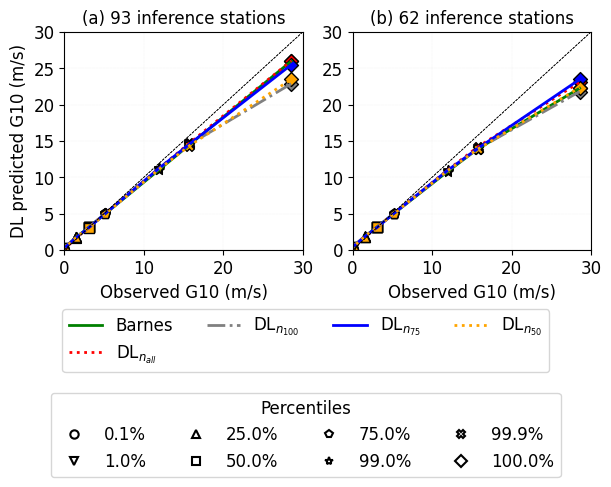

In [52]:


percentiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999,1]
colors = ['green', 'red', 'grey', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles

fontsize = 12
fig = plt.figure(figsize=(6, 3), constrained_layout=True)
gs = fig.add_gridspec(1,2)
inference_stations = [93, 62]
train_handles = []  # Store handles for station legend
percentile_handles = []  # Store handles for percentile legend (only created once)
for i,(all_preds, target_data) in enumerate(zip([data_93['predictions'], data_62['predictions']], [data_93['target'], data_62['target']])):
    ax = fig.add_subplot(gs[i])
    fig_labels = ['Barnes', fr'DL$_{{n_{{all}}}}$', fr'DL$_{{n_{{100}}}}$', fr'DL$_{{n_{{75}}}}$', fr'DL$_{{n_{{50}}}}$']
    line_styles = ['-', ':', '-.', '-', ':']
    for j,(label,test_data) in enumerate(all_preds.items()):

        # Flatten the data for plotting
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Step 2: Create a mask of valid (non-NaN) values across all
        valid_mask = (
            ~np.isnan(test_1d) &
            ~np.isnan(target_1d)
        )
        # Step 3: Apply the mask to all arrays
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Compute quantiles for 
        x_quantiles = np.quantile(target_clean, percentiles)
        y_quantiles = np.quantile(test_clean, percentiles)

        line, = ax.plot(x_quantiles, y_quantiles, linestyle=line_styles[j], color=colors[j], label=fig_labels[j], linewidth=2)
        if i == 0:  # Only add the first line to the legend
            train_handles.append(line)  # Store for legend

        # Add markers for different percentiles
        for l in range(len(percentiles)):
            marker_point = ax.scatter(x_quantiles[l], y_quantiles[l], facecolors=colors[j], marker=markers[l], s=50, edgecolors='black')
            if i == 0 and j == 0:  # Only add the first marker to the legend
                percentile_handles.append(marker_point)  # Store for legend

    # Reference line
    ax.plot([0, 30], [0, 30], 'k--', linewidth=0.5)

    # Set plot limits
    min_value, max_value =0, 30
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add 1:1 reference line
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', linewidth=0.5)

    # Labels, titles, and formatting
    xlabel = 'Observed G10 (m/s)'
    ylabel = f'DL predicted G10 (m/s)' if i==0 else ''
    title = f'({small_alphabets[i]}) {inference_stations[i]} inference stations'
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set dashed grid lines with specified line thickness
    ax.grid(True, linestyle=':', linewidth=0.1)

    #ax.legend(loc='upper left', fontsize=fontsize,frameon=False)

# Create a common legend for stations (lines)
bbox_to_anchor = (0.5, -0.25)
fig.legend(handles=train_handles, loc='lower center', ncol=4, 
            bbox_to_anchor=bbox_to_anchor, fontsize=fontsize)

# Create a second legend for percentiles (markers) with black edges
legend_markers = [plt.Line2D([0], [0], marker=markers[k], color='black', markersize=6, linestyle='None', 
                                markerfacecolor='none', markeredgecolor='black', markeredgewidth=1.5) 
                    for k in range(len(percentiles))]
bbox_to_anchor = (0.5, -0.6)
fig.legend(handles=legend_markers, labels=[f'{p*100:.1f}%' for p in percentiles], loc='lower center', 
            bbox_to_anchor=bbox_to_anchor, ncol=4, fontsize=fontsize, title="Percentiles", title_fontsize=fontsize)
plt.savefig(f'{FIG_DIR}/{variable}_quantile_comparison_training_stations_strategy_sensitivity.png', dpi=300, bbox_inches='tight')

### Precision, recall, and F1

In [12]:
for i,(all_preds, target_data) in enumerate(zip([data_93['predictions'], data_62['predictions']], [data_93['target'], data_62['target']])):
    for j,(label,test_data) in enumerate(all_preds.items()):

        # Flatten the data for plotting
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Step 2: Create a mask of valid (non-NaN) values across all
        valid_mask = (
            ~np.isnan(test_1d) &
            ~np.isnan(target_1d)
        )
        # Step 3: Apply the mask to all arrays
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Threshold for gust classification
        threshold = 17.5
        # Apply threshold (gust >= 17.5 m/s → 1, else 0)
        target_binary = (target_clean >= threshold).astype(int)
        test_binary = (test_clean >= threshold).astype(int)

        TP = ((target_binary == 1) & (test_binary == 1)).sum()
        TN = ((target_binary == 0) & (test_binary == 0)).sum()
        FP = ((target_binary == 0) & (test_binary == 1)).sum()
        FN = ((target_binary == 1) & (test_binary == 0)).sum()  

        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(label, f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

Barnes Interp Accuracy: 0.9996, Precision: 0.2301, Recall: 0.0833, F1 Score: 0.1223
DL_{n_{all}} Accuracy: 0.9996, Precision: 0.2081, Recall: 0.0844, F1 Score: 0.1201
DL_{n_{100}} Accuracy: 0.9997, Precision: 0.3650, Recall: 0.1099, F1 Score: 0.1689
DL_{n_{75}} Accuracy: 0.9997, Precision: 0.4086, Recall: 0.1228, F1 Score: 0.1889
DL_{n_{50}} Accuracy: 0.9997, Precision: 0.4616, Recall: 0.1071, F1 Score: 0.1738
Barnes Interp Accuracy: 0.9997, Precision: 0.3343, Recall: 0.0617, F1 Score: 0.1041
DL_{n_{all}} Accuracy: 0.9997, Precision: 0.2985, Recall: 0.0619, F1 Score: 0.1026
DL_{n_{100}} Accuracy: 0.9997, Precision: 0.5324, Recall: 0.0679, F1 Score: 0.1204
DL_{n_{75}} Accuracy: 0.9997, Precision: 0.5978, Recall: 0.0859, F1 Score: 0.1502
DL_{n_{50}} Accuracy: 0.9997, Precision: 0.6117, Recall: 0.0650, F1 Score: 0.1175


In [13]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

threshold = 17.5

inference_cases = [(data_93, '93 Inference Stations'), (data_62, '62 Inference Stations')]
fig_labels = ['Barnes Interp', fr'DL$_{{n_{{all}}}}$', fr'DL$_{{n_{{100}}}}$', fr'DL$_{{n_{{75}}}}$', fr'DL$_{{n_{{50}}}}$']
pr_results = {}  # <-- Dictionary to store PR results

for i, (data_dict, title_prefix) in enumerate(inference_cases):
    all_preds = data_dict['predictions']
    target_data = data_dict['target']

    key_prefix = '93' if '93' in title_prefix else '62'
    pr_results[key_prefix] = {}

    for j, (label, test_data) in enumerate(all_preds.items()):
        # Flatten
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Mask valid
        valid_mask = ~np.isnan(test_1d) & ~np.isnan(target_1d)
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Binary classification
        target_binary = (target_clean >= threshold).astype(int)

        # PR Curve
        precision, recall, thresholds = precision_recall_curve(target_binary, test_clean)
        pr_auc = auc(recall, precision)

        # Save to dictionary
        pr_results[key_prefix][label] = {
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds,
            'auc': pr_auc
        }

        print(f"{key_prefix} - {label} - PR AUC: {pr_auc:.4f}")

93 - Barnes Interp - PR AUC: 0.0836
93 - DL_{n_{all}} - PR AUC: 0.0734
93 - DL_{n_{100}} - PR AUC: 0.1522
93 - DL_{n_{75}} - PR AUC: 0.1697
93 - DL_{n_{50}} - PR AUC: 0.1720
62 - Barnes Interp - PR AUC: 0.1073
62 - DL_{n_{all}} - PR AUC: 0.0927
62 - DL_{n_{100}} - PR AUC: 0.1708
62 - DL_{n_{75}} - PR AUC: 0.1923
62 - DL_{n_{50}} - PR AUC: 0.1838


93 - Barnes Interp - PR AUC: 0.0836, 10567035
93 - DL_{n_{all}} - PR AUC: 0.0734, 9298516
93 - DL_{n_{100}} - PR AUC: 0.1522, 9163720
93 - DL_{n_{75}} - PR AUC: 0.1697, 9168427
93 - DL_{n_{50}} - PR AUC: 0.1720, 8815951
62 - Barnes Interp - PR AUC: 0.1073, 9988798
62 - DL_{n_{all}} - PR AUC: 0.0927, 9897020
62 - DL_{n_{100}} - PR AUC: 0.1708, 9767881
62 - DL_{n_{75}} - PR AUC: 0.1923, 9817561
62 - DL_{n_{50}} - PR AUC: 0.1838, 9808922


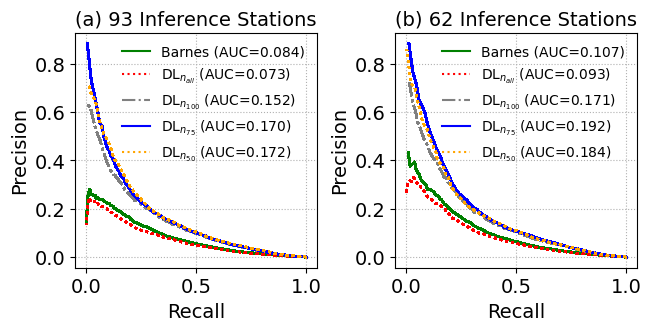

In [50]:
fontsize = 14
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3.2), constrained_layout=True)
axs = axs.flatten()
colors = ['green', 'red', 'grey', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles
line_styles = ['-', ':', '-.', '-', ':']
fig_labels = ['Barnes', fr'DL$_{{n_{{all}}}}$', fr'DL$_{{n_{{100}}}}$', fr'DL$_{{n_{{75}}}}$', fr'DL$_{{n_{{50}}}}$']
train_handles = []  # Store handles for station legend
for i, key in enumerate(['93', '62']):
    ax = axs[i]
    ax.set_title(f"({chr(97+i)}) {key} Inference Stations", fontsize=fontsize)
    ax.set_xlabel("Recall", fontsize=fontsize)
    ax.set_ylabel("Precision", fontsize=fontsize)

    for j, label in enumerate(pr_results[key].keys()):
        #j,label = 0, 'Barnes Interp'  # Only plotting Barnes Interp for simplicity
        result = pr_results[key][label]
        ax.plot(result['recall'][::100], result['precision'][::100], label=f"{fig_labels[j]} (AUC={result['auc']:.3f})", color=colors[j],linestyle=line_styles[j],linewidth=1.5, 
                #marker='.',markersize=5,
                antialiased=False)
        print(f"{key} - {label} - PR AUC: {result['auc']:.4f}, {len(result['recall'])}")

    ax.grid(True, linestyle=":")
    ax.legend(fontsize=fontsize - 4,frameon=False)
    ax.tick_params(labelsize=fontsize, which='both')

# Create a common legend for stations (lines)
#bbox_to_anchor = (0.5, -0.2)
#fig.legend(handles=train_handles, loc='lower center', ncol=5, 
#            bbox_to_anchor=bbox_to_anchor, fontsize=fontsize)

plt.savefig(f'{FIG_DIR}/{variable}_PR_curve_comparison_training_stations_strategy_sensitivity.png', dpi=300, bbox_inches='tight')

# Sensitivity to Loss functions

## Time-series comparison with NYSM

In [53]:
prediction_dir = 'Predictions'
variable = 'i10fg'
model = 'UNet'
stations_seed = 42
data_type = 'NYSM'

def process_predictions_across_losses(n_infer, FOLDS):
    labels = ['Barnes Interp', 'Charbonnier', 'MSE', 'MAE+Quantile']
    all_preds = {label: [] for label in labels}
    target_data_list = []

    for group, folds in zip(selected_groups, FOLDS):
        test_stations = group
        local_y_indices = y_indices[test_stations]
        local_x_indices = x_indices[test_stations]
        local_station_indices = station_indices[test_stations]

        indexers = {
            'y': xr.DataArray(local_y_indices, dims='point'),
            'x': xr.DataArray(local_x_indices, dims='point')
        }

        preds_per_label = {label: [] for label in labels}

        for fold in folds:
            zarr_paths = []
            zarr_paths.append(f"{prediction_dir}/Barnes_interpolated/{n_infer}-inference-stations/fold_{fold}/{data_type}_test.zarr")

            for loss in ["MaskedCharbonnierLoss", "MaskedMSELoss", "MaskedCombinedMAEQuantileLoss"]:
                train_val = 75
                train_dir = f'{stations_seed}/{train_val}-random-stations-per-sample' if train_val != 'all' else 'all-stations'
                zarr_paths.append(
                    f'{prediction_dir}/{variable}/{model}/orography-si10-t2m-sh2/2018-2021/{train_dir}/{loss}/standard/gelu-42/{n_infer}-inference-stations/fold_{fold}/{data_type}_test.zarr'
                )

            for label, path in zip(labels, zarr_paths):
                test_ds = xr.open_zarr(path)[variable].sel(time=slice(*test_dates_range))
                test_data = test_ds.isel(**indexers).transpose('time', 'point')
                preds_per_label[label].append(test_data)

        for label in labels:
            all_preds[label].append(xr.concat(preds_per_label[label], dim='fold').mean(dim='fold'))

        target_ds = NYSM[variable].sel(time=slice(*test_dates_range))
        target_data = target_ds.isel(station=local_station_indices)
        target_data_list.append(target_data)

    for label in labels:
        with ProgressBar():
            all_preds[label] = xr.concat(all_preds[label], dim='point').load()

    target_data = xr.concat(target_data_list, dim='station')
    with ProgressBar():
        target_data = target_data.T.values

    return {"predictions": all_preds, "target": target_data}

In [54]:
# === Prepare and save for 93
data_93 = process_predictions_across_losses(
    n_infer=93,
    FOLDS=[[3],[2],[1],[0]]
)
# === Prepare and save for 62
data_62 = process_predictions_across_losses(
    n_infer=62,
    FOLDS=[[2,3,5],[1,2,4],[0,1,5],[0,3,4]]
)

[########################################] | 100% Completed | 28.79 s
[########################################] | 100% Completed | 11.11 s
[########################################] | 100% Completed | 34.60 s
[########################################] | 100% Completed | 28.89 s
[########################################] | 100% Completed | 70.45 s
[########################################] | 100% Completed | 46.45 s
[########################################] | 100% Completed | 67.76 s
[########################################] | 100% Completed | 45.77 s


### Quantile comparison

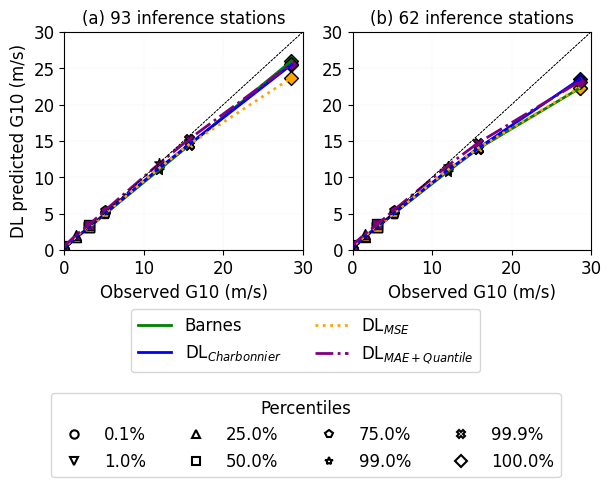

In [59]:


percentiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999,1]
colors = ['green', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles

fontsize = 12
fig = plt.figure(figsize=(6, 3), constrained_layout=True)
gs = fig.add_gridspec(1,2)
inference_stations = [93, 62]
train_handles = []  # Store handles for station legend
percentile_handles = []  # Store handles for percentile legend (only created once)
for i,(all_preds, target_data) in enumerate(zip([data_93['predictions'], data_62['predictions']], [data_93['target'], data_62['target']])):
    ax = fig.add_subplot(gs[i])
    fig_labels = ['Barnes', fr'DL$_{{Charbonnier}}$', fr'DL$_{{MSE}}$', fr'DL$_{{MAE+Quantile}}$']
    line_styles = ['-', '-', ':', '-.', ':']
    for j,(label,test_data) in enumerate(all_preds.items()):

        # Flatten the data for plotting
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Step 2: Create a mask of valid (non-NaN) values across all
        valid_mask = (
            ~np.isnan(test_1d) &
            ~np.isnan(target_1d)
        )
        # Step 3: Apply the mask to all arrays
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Compute quantiles for 
        x_quantiles = np.quantile(target_clean, percentiles)
        y_quantiles = np.quantile(test_clean, percentiles)

        line, = ax.plot(x_quantiles, y_quantiles, linestyle=line_styles[j], color=colors[j], label=fig_labels[j], linewidth=2)
        if i == 0:  # Only add the first line to the legend
            train_handles.append(line)  # Store for legend

        # Add markers for different percentiles
        for l in range(len(percentiles)):
            marker_point = ax.scatter(x_quantiles[l], y_quantiles[l], facecolors=colors[j], marker=markers[l], s=50, edgecolors='black')
            if i == 0 and j == 0:  # Only add the first marker to the legend
                percentile_handles.append(marker_point)  # Store for legend

    # Reference line
    ax.plot([0, 30], [0, 30], 'k--', linewidth=0.5)

    # Set plot limits
    min_value, max_value =0, 30
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add 1:1 reference line
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', linewidth=0.5)

    # Labels, titles, and formatting
    xlabel = 'Observed G10 (m/s)'
    ylabel = f'DL predicted G10 (m/s)' if i==0 else ''
    title = f'({small_alphabets[i]}) {inference_stations[i]} inference stations'
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set dashed grid lines with specified line thickness
    ax.grid(True, linestyle=':', linewidth=0.1)

    #ax.legend(loc='upper left', fontsize=fontsize,frameon=False)

# Create a common legend for stations (lines)
bbox_to_anchor = (0.5, -0.25)
fig.legend(handles=train_handles, loc='lower center', ncol=2, 
            bbox_to_anchor=bbox_to_anchor, fontsize=fontsize)

# Create a second legend for percentiles (markers) with black edges
legend_markers = [plt.Line2D([0], [0], marker=markers[k], color='black', markersize=6, linestyle='None', 
                                markerfacecolor='none', markeredgecolor='black', markeredgewidth=1.5) 
                    for k in range(len(percentiles))]
bbox_to_anchor = (0.5, -0.6)
fig.legend(handles=legend_markers, labels=[f'{p*100:.1f}%' for p in percentiles], loc='lower center', 
            bbox_to_anchor=bbox_to_anchor, ncol=4, fontsize=fontsize, title="Percentiles", title_fontsize=fontsize)
plt.savefig(f'{FIG_DIR}/{variable}_quantile_comparison_loss_sensitivity.png', dpi=300, bbox_inches='tight')

### Precision, recall, and F1

In [60]:
for i,(all_preds, target_data) in enumerate(zip([data_93['predictions'], data_62['predictions']], [data_93['target'], data_62['target']])):
    for j,(label,test_data) in enumerate(all_preds.items()):

        # Flatten the data for plotting
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Step 2: Create a mask of valid (non-NaN) values across all
        valid_mask = (
            ~np.isnan(test_1d) &
            ~np.isnan(target_1d)
        )
        # Step 3: Apply the mask to all arrays
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Threshold for gust classification
        threshold = 17.5
        # Apply threshold (gust >= 17.5 m/s → 1, else 0)
        target_binary = (target_clean >= threshold).astype(int)
        test_binary = (test_clean >= threshold).astype(int)

        TP = ((target_binary == 1) & (test_binary == 1)).sum()
        TN = ((target_binary == 0) & (test_binary == 0)).sum()
        FP = ((target_binary == 0) & (test_binary == 1)).sum()
        FN = ((target_binary == 1) & (test_binary == 0)).sum()  

        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(label, f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

Barnes Interp Accuracy: 0.9996, Precision: 0.2301, Recall: 0.0833, F1 Score: 0.1223
Charbonnier Accuracy: 0.9997, Precision: 0.4086, Recall: 0.1228, F1 Score: 0.1889
MSE Accuracy: 0.9997, Precision: 0.3935, Recall: 0.1148, F1 Score: 0.1778
MAE+Quantile Accuracy: 0.9996, Precision: 0.2915, Recall: 0.1829, F1 Score: 0.2248
Barnes Interp Accuracy: 0.9997, Precision: 0.3343, Recall: 0.0617, F1 Score: 0.1041
Charbonnier Accuracy: 0.9997, Precision: 0.5978, Recall: 0.0859, F1 Score: 0.1502
MSE Accuracy: 0.9997, Precision: 0.6134, Recall: 0.0851, F1 Score: 0.1495
MAE+Quantile Accuracy: 0.9997, Precision: 0.4370, Recall: 0.1298, F1 Score: 0.2001


In [61]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

threshold = 17.5

inference_cases = [(data_93, '93 Inference Stations'), (data_62, '62 Inference Stations')]
pr_results = {}  # <-- Dictionary to store PR results

for i, (data_dict, title_prefix) in enumerate(inference_cases):
    all_preds = data_dict['predictions']
    target_data = data_dict['target']

    key_prefix = '93' if '93' in title_prefix else '62'
    pr_results[key_prefix] = {}

    for j, (label, test_data) in enumerate(all_preds.items()):
        # Flatten
        test_1d = test_data.values.flatten()
        target_1d = target_data.flatten()

        # Mask valid
        valid_mask = ~np.isnan(test_1d) & ~np.isnan(target_1d)
        test_clean = test_1d[valid_mask]
        target_clean = target_1d[valid_mask]

        # Binary classification
        target_binary = (target_clean >= threshold).astype(int)

        # PR Curve
        precision, recall, thresholds = precision_recall_curve(target_binary, test_clean)
        pr_auc = auc(recall, precision)

        # Save to dictionary
        pr_results[key_prefix][label] = {
            'precision': precision,
            'recall': recall,
            'thresholds': thresholds,
            'auc': pr_auc
        }

        print(f"{key_prefix} - {label} - PR AUC: {pr_auc:.4f}")

93 - Barnes Interp - PR AUC: 0.0836
93 - Charbonnier - PR AUC: 0.1697
93 - MSE - PR AUC: 0.1611
93 - MAE+Quantile - PR AUC: 0.1500
62 - Barnes Interp - PR AUC: 0.1073
62 - Charbonnier - PR AUC: 0.1923
62 - MSE - PR AUC: 0.1947
62 - MAE+Quantile - PR AUC: 0.1810


93 - Barnes Interp - PR AUC: 0.0836, 10567035
93 - Charbonnier - PR AUC: 0.1697, 9168427
93 - MSE - PR AUC: 0.1611, 9151963
93 - MAE+Quantile - PR AUC: 0.1500, 9295991
62 - Barnes Interp - PR AUC: 0.1073, 9988798
62 - Charbonnier - PR AUC: 0.1923, 9817561
62 - MSE - PR AUC: 0.1947, 9744200
62 - MAE+Quantile - PR AUC: 0.1810, 9620178


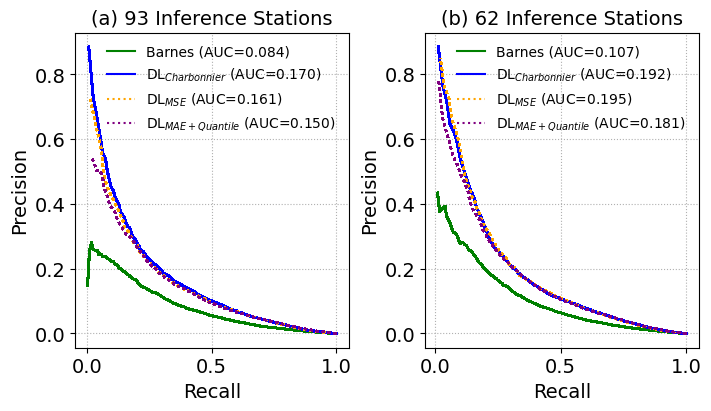

In [65]:
fontsize = 14
fig, axs = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
axs = axs.flatten()
colors = ['green', 'blue', 'orange', 'purple', 'brown', 'cyan']
markers = ['o', 'v', '^', 's', 'p', '*', 'X', 'D']  # Different markers for percentiles
line_styles = ['-', '-', ':', ':', '-.']
fig_labels = ['Barnes', fr'DL$_{{Charbonnier}}$', fr'DL$_{{MSE}}$', fr'DL$_{{MAE+Quantile}}$']
train_handles = []  # Store handles for station legend
for i, key in enumerate(['93', '62']):
    ax = axs[i]
    ax.set_title(f"({chr(97+i)}) {key} Inference Stations", fontsize=fontsize)
    ax.set_xlabel("Recall", fontsize=fontsize)
    ax.set_ylabel("Precision", fontsize=fontsize)

    for j, label in enumerate(pr_results[key].keys()):
        #j,label = 0, 'Barnes Interp'  # Only plotting Barnes Interp for simplicity
        result = pr_results[key][label]
        ax.plot(result['recall'][::100], result['precision'][::100], label=f"{fig_labels[j]} (AUC={result['auc']:.3f})", color=colors[j],linestyle=line_styles[j],linewidth=1.5, 
                #marker='.',markersize=5,
                antialiased=False)
        print(f"{key} - {label} - PR AUC: {result['auc']:.4f}, {len(result['recall'])}")

    ax.grid(True, linestyle=":")
    ax.legend(fontsize=fontsize - 4,frameon=False)
    ax.tick_params(labelsize=fontsize, which='both')

plt.savefig(f'{FIG_DIR}/{variable}_PR_curve_comparison_loss_sensitivity.png', dpi=300, bbox_inches='tight')